In [389]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
import eli5

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from eli5.sklearn import PermutationImportance



In [390]:
test = pd.read_csv('./test.csv')
train = pd.read_csv('./train.csv')


In [391]:
train.info(verbose = True)
test.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  

In [392]:
train['set'] = 1
test['set'] = 0
train_test=train.append(other = test)
train_test.reset_index(drop = False, inplace = True)

In [393]:
train_test.isnull().sum()


index              0
PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
set                0
dtype: int64

In [394]:

# Dealing with missing value in CryoSleep with billing feature vice versa
non_sleeping_features = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
train_test.loc[:,non_sleeping_features]=train_test.apply(lambda x: 0 if x.CryoSleep == True else x,axis =1)
train_test['Expenses'] = train_test.loc[:,non_sleeping_features].sum(axis=1)
train_test.loc[:,['CryoSleep']]=train_test.apply(lambda x: True if x.Expenses == 0 and pd.isna(x.CryoSleep) else x,axis =1)
train_test.loc[:,['CryoSleep']]=train_test.apply(lambda x: False if x.Expenses != 0 and pd.isna(x.CryoSleep) else x,axis =1)

In [ ]:
train_test.loc[:,['FirstName']] = train_test.Name.str.split(" ",expand=True).iloc[:,0]
train_test.loc[:,['LastName']] = train_test.Name.str.split(" ",expand=True).iloc[:,1]

In [395]:
# Generate new feature from existing features
train_test.loc[:,['group']] = train_test.PassengerId.apply(lambda x: x[0:4] ).astype('int')
train_test.loc[:,['id']] = train_test.PassengerId.apply(lambda x: x.split("_")[1]).astype('int')

train_test['group_size']=train_test['group'].map(lambda x: train_test['group'].value_counts()[x])
train_test["Financial"] = train_test["Expenses"].apply(lambda x: "poor" if x < 5000 else ("middle" if x>5000 and x<20000 else "rich"))

In [397]:
def add_traveller_type(df):

    checkdict ={

    }
    newColumnTravellerType = []

    for index in range(len(df)):
        gggg =df.iloc[index]['PassengerId'].split('_')[0]
        if df.iloc[index]['Name'] != df.iloc[index]['Name'] :
            lastname = 'NA'
        else :
            lastname =df.iloc[index]['Name'].split(' ')[1]
        if gggg in checkdict:
            checkdict[gggg].append(lastname)
        else :
            checkdict[gggg] = [lastname]

    for index in range(len(df)):
        gggg =df.iloc[index]['PassengerId'].split('_')[0]
        lastnames = checkdict[gggg]
        lastname = 'NA'
        if df.iloc[index]['Name'] == df.iloc[index]['Name'] :
            lastname =df.iloc[index]['Name'].split(' ')[1]

        if len(lastnames) == 1:
            newColumnTravellerType.append('INDIVIDUAL')
        elif len(lastnames) > 1:
            if lastname != 'NA' and lastnames.count(lastname) > 1:
                newColumnTravellerType.append('FAMILY')
            else :
                newColumnTravellerType.append('GROUP')

    df['TravellerType'] = newColumnTravellerType
    return df

train_test=  add_traveller_type(train_test)

In [ ]:
def cabin_regions(df):
    df["Cabin_Region1"] = (df["Cabin_Number"]<300)
    df["Cabin_Region2"] = (df["Cabin_Number"]>=300) & (df["Cabin_Number"]<600)
    df["Cabin_Region3"] = (df["Cabin_Number"]>=600) & (df["Cabin_Number"]<900)
    df["Cabin_Region4"] = (df["Cabin_Number"]>=900) & (df["Cabin_Number"]<1200)
    df["Cabin_Region5"] = (df["Cabin_Number"]>=1200) & (df["Cabin_Number"]<1500)
    df["Cabin_Region6"] = (df["Cabin_Number"]>=1500)

train_test = cabin_regions(train_test)

In [398]:
# From inspecting impact of same group's member, we can found out that same group's members come from 
# same planet and has high probability is from same family (i.e same last name), same cabin

group_Cabin     = train_test.loc[:,['group','Cabin']].dropna().drop_duplicates('group')
group_LastName = train_test.loc[:,['group','LastName']].dropna().drop_duplicates('group')
group_HomePlanet  = train_test.loc[:,['group','HomePlanet']].dropna().drop_duplicates('group')
train_test      = pd.merge(train_test,group_Cabin,how="left",on='group',suffixes=('','_y'))
train_test      = pd.merge(train_test,group_LastName,how="left",on='group',suffixes=('','_y'))
train_test      = pd.merge(train_test,group_HomePlanet,how="left",on='group',suffixes=('','_y'))

# Fill in the missing value related to group
train_test.loc[:,['Cabin']]=train_test.apply(lambda x:  x.Cabin_y if pd.isna(x.Cabin) else x,axis=1)
train_test.loc[:,['HomePlanet']]=train_test.apply(lambda x:  x.HomePlanet_y if pd.isna(x.HomePlanet) else x,axis=1)
train_test.loc[:,['LastName']]=train_test.apply(lambda x:  x.LastName_y if pd.isna(x.LastName) else x,axis=1)

In [399]:

train_test.loc[:,['Cabin_deck']] = train_test.Cabin.str.split("/",expand=True).iloc[:,0]
train_test.loc[:,['Cabin_num']] = train_test.Cabin.str.split("/",expand=True).iloc[:,1]
train_test.loc[:,['Cabin_side']] = train_test.Cabin.str.split("/",expand=True).iloc[:,2]

train_test['Cabin_num' ].fillna(value = -1, inplace = True)
train_test['Cabin_num'] = train_test['Cabin_num'].astype(dtype = 'int')


In [400]:
df = train_test[train_test.duplicated('group', keep=False)].sort_values('group')
df.to_csv('group_inspect.csv', index=False)

In [401]:
df = train_test.sort_values('group')
df.to_csv('group_inspect.csv', index=False)

In [402]:
num_cols = ['ShoppingMall','FoodCourt','RoomService','Spa','VRDeck','Age']
cat_cols = ['CryoSleep','Cabin_deck', 'Cabin_side','VIP','HomePlanet','Destination', 'TravellerType', 'Financial']
transported=['Transported']
train_test_1 = train_test[num_cols+cat_cols+transported+['group_size','Expenses', 'Cabin_num','set']].copy()

num_imp = SimpleImputer(strategy='mean')
cat_imp = SimpleImputer(strategy='most_frequent')
ohe = OneHotEncoder (handle_unknown='ignore',sparse = False)
le = LabelEncoder()

# Filling other missing value unrelated to group
train_test[num_cols] = pd.DataFrame(num_imp.fit_transform(train_test_1[num_cols]),columns=num_cols)
train_test[cat_cols] = pd.DataFrame(cat_imp.fit_transform(train_test_1[cat_cols]),columns=cat_cols)
temp_train = pd.DataFrame(ohe.fit_transform(train_test_1[cat_cols]),columns= ohe.get_feature_names_out())
train_test_1 = train_test_1.drop(cat_cols,axis=1)
train_test_1 = pd.concat([train_test_1,temp_train],axis=1)
train_test['Expenses'] = train_test.loc[:,non_sleeping_features].sum(axis=1)


/home/andrew/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [403]:
def get_score(model,X,y):
    n = cross_val_score(model,X,y,scoring ='accuracy',cv=20)
    return n

In [404]:
train_test_1

,ShoppingMall,FoodCourt,RoomService,Spa,VRDeck,Age,Transported,group,group_size,Expenses,...,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Destination_nan,TravellerType_FAMILY,TravellerType_GROUP,TravellerType_INDIVIDUAL,Financial_middle,Financial_poor,Financial_rich
0,0.0,0.0,0.0,0.0,0.0,39.0,False,1,1,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,25.0,9.0,109.0,549.0,44.0,24.0,True,2,1,736.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,3576.0,43.0,6715.0,49.0,58.0,False,3,2,10383.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,371.0,1283.0,0.0,3329.0,193.0,33.0,False,3,2,5176.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,151.0,70.0,303.0,565.0,2.0,16.0,True,4,1,1091.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,0.0,0.0,0.0,0.0,0.0,34.0,NaN,9266,2,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
12966,17.0,847.0,0.0,10.0,144.0,42.0,NaN,9269,1,1018.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
12967,0.0,0.0,0.0,0.0,0.0,NaN,NaN,9271,1,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
12968,0.0,2680.0,0.0,0.0,523.0,NaN,NaN,9273,1,3203.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [417]:
train = train_test_1[train_test['set']== 1].copy()
train.Transported =train.Transported.astype('int')
test = train_test_1[train_test['set'] == 0].drop("Transported",axis=1)
test = test.drop('set',axis=1)

In [418]:
X = train.drop(['set','Transported'],axis=1)
y = train.Transported

In [419]:
X,y = shuffle(X,y)
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [408]:
params_XGB_best= {  'tree_method': "hist",
                    'lambda': 3, 
                    'alpha': 4.58, 
                    'colsample_bytree': 0.9, 
                    'subsample': 0.95, 
                    'learning_rate': 0.07, 
                    'n_estimators': 800, 
                    'max_depth': 4, 
                    'min_child_weight': 1, 
                    'num_parallel_tree': 1}
print(get_score(xgb.XGBClassifier(**params_XGB_best),X,y).mean())

0.8098503628370146


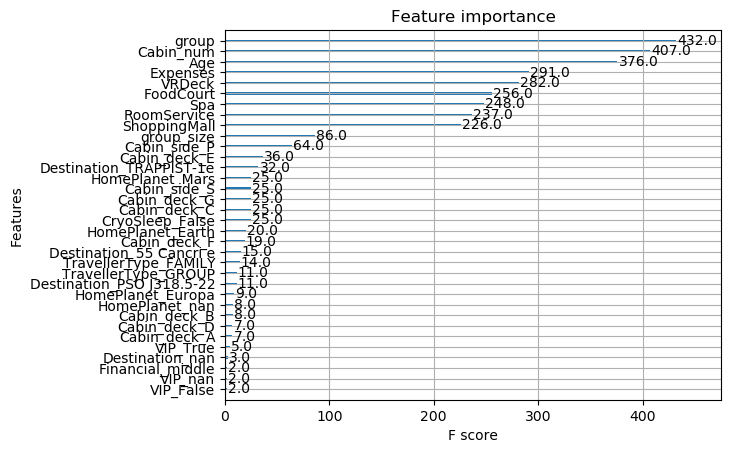

In [409]:
model = xgb.XGBClassifier()
model.fit(X, y)
xgb.plot_importance(model)

In [420]:
good_feature = ['group', 'Cabin_num', 'Age', 'Expenses', 'VRDeck', 'FoodCourt', 'ShoppingMall',
                'Spa', 'RoomService', 'group_size','Cabin_side_P']
train = train[good_feature]
test = test[good_feature]

X = train

print(get_score(xgb.XGBClassifier(**params_XGB_best),X,y).mean())

0.4459126542719424


In [ ]:
perm = PermutationImportance(xgb.XGBClassifier(**params_XGB_best), random_state=1,n_iter =10,cv=5).fit(X, y)
eli5.show_weights(perm, feature_names = X.columns.tolist(),top=50)

Weight,Feature
0.0387 ± 0.0136,VRDeck
0.0377 ± 0.0123,Spa
0.0361 ± 0.0159,CryoSleep_False
0.0347 ± 0.0161,FoodCourt
0.0235 ± 0.0091,RoomService
0.0163 ± 0.0171,Expenses
0.0105 ± 0.0136,ShoppingMall
0.0088 ± 0.0147,Cabin_num
0.0075 ± 0.0110,Age
0.0073 ± 0.0118,Cabin_side_S


In [ ]:
# drop_list=['VIP_True', 'Destination_nan', 'Destination_55 Cancri e', 'HomePlanet_nan', 'Destination_PSO J318.5-22']
# X=X.drop(drop_list,axis=1)
# test=test.drop(drop_list,axis=1)
# print(get_score(xgb.XGBClassifier(**params_XGB_best),X,y).mean())

In [ ]:
test

,ShoppingMall,FoodCourt,RoomService,Spa,VRDeck,Age,Expenses,Cabin_num,CryoSleep_False,CryoSleep_True,...,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Destination_nan,TravellerType_FAMILY,TravellerType_GROUP,TravellerType_INDIVIDUAL,Financial_middle,Financial_poor,Financial_rich
8693,0.0,0.0,0.0,0.0,0.0,27.0,0.0,3,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
8694,0.0,9.0,0.0,2823.0,0.0,19.0,2832.0,4,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
8695,0.0,0.0,0.0,0.0,0.0,31.0,0.0,0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
8696,0.0,6652.0,0.0,181.0,585.0,38.0,7418.0,1,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
8697,635.0,0.0,10.0,0.0,0.0,20.0,645.0,5,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,0.0,0.0,0.0,0.0,0.0,34.0,0.0,1496,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
12966,17.0,847.0,0.0,10.0,144.0,42.0,1018.0,-1,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
12967,0.0,0.0,0.0,0.0,0.0,NaN,0.0,296,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
12968,0.0,2680.0,0.0,0.0,523.0,NaN,3203.0,297,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
pred_XGB_best = (xgb.XGBClassifier(**params_XGB_best).fit(X,y)).predict(test)
sample = pd.read_csv('./sample_submission.csv')
sample['Transported'] = pred_XGB_best
sample['Transported']=sample['Transported']>0.5
sample.to_csv('311605002.csv', index=False)